# Two-level AMG+ for 1D Helmholtz / Repetitive
* Constant $k$. $k h$ designed so that wavelength evenly divides the domain.
* Discretization: 5-point (4th order).
* Kaczmarz relaxation.
* Fixed-domain problem; repetitive, so we sample windows from a test vector.
* Using ideal TVs.
* Interpolation LS fitting is weighted by $\|A x^{(k)}\|^{-1}$, where $k$ runs over test functions, and the norm is local (over 3 aggregates when fitting interpolation in an aggregate). This forces the interpolation row sums to be $1$, as the constant null-space vector has infinite LS weight. Thus $A^c$ is exactly singular and $b^c$ is exactly compatible with it at the coarse level in the cycle.
* $A^c = P^T A Q$ is constructed locally and tiled, so that there is no fill-in due to $P$ in $P^T A P$.

In [129]:
%run /Users/olivne/helmholtz/src/helmholtz/startup.ipy

In [74]:
# Fixed seed for reproducible results.
np.random.seed(2)

# Domain size.
n = 96
# Scaled wave number. Fit so lam_min = 0 (integer # periods in domain).
discretization = "5-point"
#kh = 0
kh = helmholtz.analysis.ideal.find_singular_kh(discretization, n)[0]

repetitive = True

# Test vectors.
ideal_tv = False    # Use eigenvectors or not.
# Number of test vectors.  
num_examples = 4
# Set # sweeps manually here.
num_sweeps_on_vectors = 300 # None
threshold = 0.1

# Boottstrapping parameters.
interpolation_method = "ls" # "weighted_ls" #"ls"
fit_scheme = "ridge"
weighted = True
neighborhood = "extended" #"aggregate" # "extended"
num_test_examples = 5
leeway_factor = 1.3

_LOGGER.info("kh {}".format(kh))

INFO     kh 0.5233853805513015


## Level 0->1 Coarsening

In [130]:
# Create fine-level matrix.
a = hm.linalg.helmholtz_1d_discrete_operator(kh, discretization, n)
# Use default = Kacmzarz relaxation for kh != 0.
level = hm.setup.hierarchy.create_finest_level(a,  relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None)

# Initialize hierarchy to 1-level.
finest = 0
multilevel = hm.setup.hierarchy.multilevel.Multilevel.create(level)

# 'location' is an array of variable locations at all levels. Used only for interpolation neighbor determination.
# Finest-level variable ocations are assumed to be [0..n-1], i.e. a domain of size n with meshsize h = 1.
level.location = np.arange(n)

# TV and TV residual history.
x_log = []
r_log = []

### Relaxation

INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     1.269e+00                    4.470e-01    2.840
INFO     1     7.058e-01 (0.556) [0.556]    3.500e-01    2.021 (0.711)
INFO     2     4.121e-01 (0.585) [0.570]    3.045e-01    1.359 (0.672)
INFO     3     2.616e-01 (0.635) [0.591]    2.807e-01    0.938 (0.690)
INFO     4     1.830e-01 (0.699) [0.617]    2.662e-01    0.692 (0.738)
INFO     5     1.405e-01 (0.768) [0.645]    2.561e-01    0.553 (0.798)
INFO     6     1.154e-01 (0.821) [0.671]    2.484e-01    0.468 (0.846)
INFO     7     9.939e-02 (0.861) [0.695]    2.422e-01    0.414 (0.883)
INFO     8     8.840e-02 (0.889) [0.717]    2.369e-01    0.376 (0.909)
INFO     9     8.008e-02 (0.905) [0.736]    2.324e-01    0.347 (0.923)
INFO     10    7.360e-02 (0.918) [0.752]    2.283e-01    0.324 (0.935)
INFO     11    6.843e-02 (0.929) [0.767]    2.247e-01    0.306 (0.944)
INFO     12    6.421e-02 (0.938) [0.780]    2.214e-01    0.291 (0.952)
INFO 

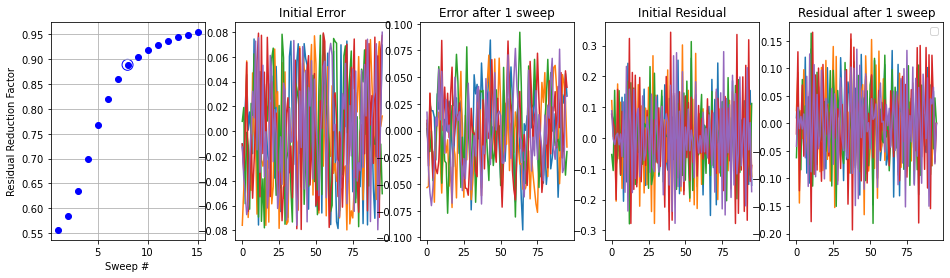

In [76]:
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    multilevel, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.95)
num_sweeps = method_info["Kaczmarz"][1]

In [77]:
nu = num_sweeps_on_vectors if num_sweeps_on_vectors is not None else num_sweeps
# Generate initial test vectors.
level = multilevel[0]
if ideal_tv:
    _LOGGER.info("Generating {} ideal TVs".format(num_examples))
    x, lam = hm.analysis.ideal.ideal_tv(level.a, num_examples)
else:
    _LOGGER.info("Generating {} TVs with {} sweeps".format(num_examples, nu))
    x = hm.setup.auto_setup.get_test_matrix(a, nu, num_examples=num_examples)
    _LOGGER.info("RER {:.3f}".format(norm(level.a.dot(x)) / norm(x)))
x_log.append(x)

INFO     Generating 4 TVs with 300 sweeps
INFO     RER 0.059


### Coarsening: Fixed (4/2)

In [78]:
# Coarsening. Force 2 coarse vars per aggregate so we can test alignment.
aggregate_size = 4
num_components = 2

# Optimize aggregate_size, num_components using mock cycle rates.
# coarsener = hm.setup.coarsening_uniform.UniformCoarsener(
#     level, x, num_sweeps, repetitive=repetitive)
# info = coarsener.get_coarsening_info(1, fmt="dataframe")
# r, aggregate_size, nc, cr, mean_energy_error, mock_conv, mock_work, mock_efficiency = \
#     coarsener.get_optimal_coarsening(1)
# _LOGGER.info("R {} a {} nc {} cr {:.2f} mean_energy_error {:.4f}; mock cycle num_sweeps {} conv {:.2f} "
#              "eff {:.2f}".format(
#     r.shape, aggregate_size, nc, cr, mean_energy_error, num_sweeps, mock_conv, mock_efficiency))
# coarsener.get_coarsening_info(1, fmt="dataframe")

,0,1,2,3,4,5,6,7,8,9
0,-0.53,-0.58,-0.51,-0.34,0.00,0.00,0.00,0.00,0.00,0.00
1,-0.60,-0.15,0.32,0.72,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,-0.53,-0.58,-0.51,-0.34,0.00,0.00
3,0.00,0.00,0.00,0.00,-0.60,-0.15,0.32,0.72,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.53,-0.58


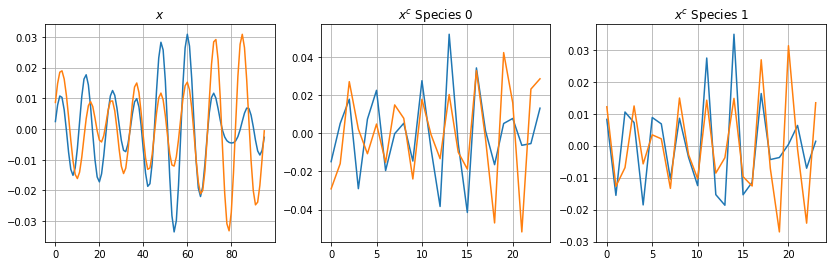

In [79]:
r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False)
R = r.tile(level.size // aggregate_size)
xc = R.dot(x)
display(pd.DataFrame(R[:5,:10].todense()))
hm.repetitive.locality.plot_coarsening(R, x)

### Local Mock Cycle (LMC) Rate
The mock cycle rate is calculated on a domain of size $4 a$, $a$ = aggregate size.

In [80]:
# Calculate local mock cycle convergence rate on a domain of size 4 * aggregate_size.
m = 4
nu_values = np.arange(1, num_sweeps + 1)
mock_conv = hm.repetitive.locality.mock_conv_factor_for_domain_size(kh, discretization, r, aggregate_size, m * aggregate_size, nu_values)
_LOGGER.info("Mock cycle conv |domain|={} {}".format(
    m * aggregate_size, np.array2string(mock_conv, precision=3)))

INFO     Mock cycle conv |domain|=16 [0.494 0.315 0.193 0.134 0.143 0.105 0.078 0.067]


### Interpolation $P = R^T$

In [81]:
# Initial guess for interpoation: P = R^T on a single aggregate.
p = r.tile(1).transpose()

two_level_conv = np.array([
    hm.repetitive.locality.two_level_conv_factor(
        hm.repetitive.locality.create_two_level_hierarchy(
            kh, discretization, m * aggregate_size, r.asarray(), p, aggregate_size, num_components), 
        nu)[1]
     for nu in nu_values])
conv = pd.DataFrame(np.array((mock_conv, two_level_conv)).transpose(), 
                    index=nu_values, columns=("Mock", "P=R^T")).transpose()

# Compare the L2 projection norm and the A*A'-orthogonal projection norms, which gives an indication
# that the mock cycle rates are guaranteed to be good predictors of the two-level rates [Rob & James].
R = r.tile(n // aggregate_size)
_LOGGER.info("L2 projection norm {:.2f} A*A' projection norm {:.2f}".
             format(norm(R.todense(), ord=2), norm((R.dot(multilevel[0].a)).todense(), ord=2)))

INFO     L2 projection norm 1.00 A*A' projection norm 2.84


### Interpolation by LS Fitting

In [92]:
calibers = (2, 3, 4)
p_experiment = {}
l2c_experiment = {}
coarsening_values = (False, True)
titles = ("P^T A P", "R A P")
for use_r_as_restriction, title in zip(coarsening_values, titles):
    l2c = []
    p_caliber = []
    for caliber in calibers:
        #print("caliber", caliber)

        p = hm.setup.auto_setup.create_interpolation(
            x, a, R, interpolation_method, aggregate_size=aggregate_size, nc=num_components, 
            neighborhood=neighborhood, repetitive=repetitive, target_error=0.1,
            caliber=caliber, fit_scheme=fit_scheme, weighted=weighted)
        #print("p row sums", np.array(p.sum(axis=1)).flatten()[:5])

        # for title, x_set in ((("all", x),) if repetitive else (("fit", x_fit), ("test", x_test))):
        #     error = norm(x_set - p.dot(R.dot(x_set)), axis=0) / norm(x_set, axis=0)
        #     error_a = norm(level.a.dot(x_set - p.dot(R.dot(x_set))), axis=0) / norm(x_set, axis=0)
        #     _LOGGER.info(
        #         "{:<4s} set size {:<2d} P L2 error mean {:.2f} max {:.2f} A error mean {:.2f} max {:.2f}".format(
        #             title, len(error), np.mean(error), np.max(error), np.mean(error_a), np.max(error_a)))

        # Initial guess for interpoation: P = R^T on a single aggregate.
        #display(pd.DataFrame(p[:6, :6].todense()))
        ml = hm.repetitive.locality.create_two_level_hierarchy(
                kh, discretization, n, R, p, aggregate_size, num_components,
                    use_r_as_restriction=use_r_as_restriction)
        ac = ml[1].a
        fill_in_factor = (ac.nnz / ml[0].a.nnz) * (ml[0].a.shape[0] / ac.shape[0])
        symmetry_deviation = np.max(np.abs(ac - ac.transpose()))
        two_level_conv = np.array([
            hm.repetitive.locality.two_level_conv_factor(
                ml, nu, print_frequency=None)[1]
             for nu in nu_values])
        l2c.append([use_r_as_restriction, caliber, p.nnz, fill_in_factor, symmetry_deviation] + list(two_level_conv))
        p_caliber.append(p)

    p_experiment[use_r_as_restriction] = p_caliber
    l2c_experiment[use_r_as_restriction] = l2c

all_conv = pd.DataFrame(np.array(
    [[np.nan] * 5 + list(row) for row in conv.values] +
    [v for use_r_as_restriction in coarsening_values for v in l2c_experiment[use_r_as_restriction]]), 
                    columns=("R A P", "Caliber", "nnz(P)", "Fill-in", "Symmetry") + tuple(nu_values), 
                        index=tuple(conv.index) + tuple("{} caliber {}".format(title, caliber) for title in titles
                          for caliber in calibers))
styler = all_conv.style.set_caption("Convergence Factors").format(precision=2)
display_html(styler._repr_html_(), raw=True)

,R A P,Caliber,nnz(P),Fill-in,Symmetry,1,2,3,4,5,6,7,8
Mock,nan,nan,nan,nan,nan,0.49,0.32,0.19,0.13,0.14,0.11,0.08,0.07
P=R^T,nan,nan,nan,nan,nan,0.55,0.40,0.48,0.48,0.45,0.44,0.44,0.42
P^T A P caliber 2,0.00,2.00,192.00,1.20,0.00,0.51,0.35,0.39,0.43,0.37,0.35,0.35,0.35
P^T A P caliber 3,0.00,3.00,288.00,1.40,0.00,0.61,0.34,0.29,0.34,0.28,0.27,0.27,0.26
P^T A P caliber 4,0.00,4.00,384.00,2.00,0.00,0.60,0.33,0.20,0.14,0.15,0.14,0.10,0.07
R A P caliber 2,1.00,2.00,192.00,1.20,0.03,0.60,0.36,0.43,0.45,0.39,0.37,0.38,0.38
R A P caliber 3,1.00,3.00,288.00,1.20,0.03,0.70,0.35,0.33,0.38,0.33,0.32,0.33,0.32
R A P caliber 4,1.00,4.00,384.00,1.20,0.01,0.70,0.37,0.28,0.22,0.18,0.14,0.10,0.08


* The SVD intepolation is good up to $\nu = 2$, conv $\approx 0.36$. This is similar to the case of Laplace + 2/1 coarsening, where $P$ is only first-order.
* Caliber 2 is equivalent to $P = R^T$.
* Caliber 3 is insufficient, oonly gives marginally better convergence than $P = R^T$.
* Caliber 4 Galerkin gives ideal rates (up to $0.11$).
* Caliber 4 $P$ with $R A P$ is slightly non-symmetric but sparser than $P^T A P$. It gives an intermediate performance between $R A R^R$ and $P^T A P$ (up to $0.18$). 

In [93]:
for use_r_as_restriction in (False, True):
    print("R*A*P" if use_r_as_restriction else "P^T*A*P")

    for caliber, p in zip(calibers, p_experiment[use_r_as_restriction]):
    #    styler = pd.DataFrame(p[:8, :8].todense()).style.set_table_attributes("style='display:inline'").set_caption("Caliber {}".format(caliber)).format(precision=2)   
    #    display_html(styler._repr_html_(), raw=True)
        ml = hm.repetitive.locality.create_two_level_hierarchy(kh, discretization, n, R, p, aggregate_size, num_components, use_r_as_restriction=use_r_as_restriction)
        ac = ml[1].a
        print("caliber {} P".format(caliber))
        display(pd.DataFrame(p[:aggregate_size, np.unique(p[:aggregate_size].nonzero()[1])].todense()))
        print("A^1")
        display(pd.DataFrame(ac[:num_components, np.unique(ac[:num_components].nonzero()[1])].todense()))
        #ac2 = ac.transpose().dot(ac)
        #display(pd.DataFrame(ac2.todense()[:14,:14]))

P^T*A*P
caliber 2 P


,0,1
0,-0.51,-0.58
1,-0.60,-0.17
2,-0.53,0.31
3,-0.31,0.72


A^1


,0,1,2,3,4,5
0,-0.19,-0.18,0.18,0.21,0.18,-0.44
1,-0.18,-1.43,-0.44,-0.54,0.21,-0.54


caliber 3 P


,0,1,2,3
0,-0.52,-0.52,0.00,-0.05
1,-0.59,-0.21,0.00,0.04
2,-0.50,0.38,0.05,0.00
3,-0.35,0.65,-0.05,0.00


A^1


,0,1,2,3,4,5,6,7
0,-0.13,-0.15,0.17,0.18,0.00,0.00,0.17,-0.37
1,-0.15,-1.18,-0.37,-0.43,0.00,0.00,0.18,-0.43


caliber 4 P


,0,1,2,3,4,5
0,-0.44,-0.37,0.00,0.00,-0.08,0.19
1,-0.65,-0.33,0.00,0.00,0.06,-0.13
2,-0.53,0.49,0.10,0.10,0.00,0.00
3,-0.31,0.49,-0.13,-0.15,0.00,0.00


A^1


,0,1,2,3,4,5,6,7,8,9
0,-0.09,-0.13,0.15,0.16,0.01,0.01,0.01,-0.02,0.15,-0.30
1,-0.13,-0.94,-0.30,-0.33,-0.02,-0.02,0.01,-0.02,0.16,-0.33


R*A*P
caliber 2 P


,0,1
0,-0.51,-0.58
1,-0.60,-0.17
2,-0.53,0.31
3,-0.31,0.72


A^1


,0,1,2,3,4,5
0,-0.20,-0.18,0.19,0.23,0.18,-0.46
1,-0.19,-1.43,-0.44,-0.53,0.22,-0.55


caliber 3 P


,0,1,2,3
0,-0.52,-0.52,0.00,-0.05
1,-0.59,-0.21,0.00,0.04
2,-0.50,0.38,0.05,0.00
3,-0.35,0.65,-0.05,0.00


A^1


,0,1,2,3,4,5
0,-0.16,-0.16,0.19,0.21,0.18,-0.41
1,-0.17,-1.28,-0.39,-0.47,0.19,-0.49


caliber 4 P


,0,1,2,3,4,5
0,-0.44,-0.37,0.00,0.00,-0.08,0.19
1,-0.65,-0.33,0.00,0.00,0.06,-0.13
2,-0.53,0.49,0.10,0.10,0.00,0.00
3,-0.31,0.49,-0.13,-0.15,0.00,0.00


A^1


,0,1,2,3,4,5
0,-0.04,-0.09,0.14,0.12,0.14,-0.21
1,-0.08,-0.60,-0.21,-0.15,0.13,-0.14


In [94]:
# Pick an interpolation operator P:1->0 to work with. We use a high-order (caliber 4) P.
p = p_experiment[False][-1]

### Solving $Ax = b$ - Convergence History

#### $P^T A P$

INFO         0 |r| 1.775e+01 RER 3.00551
INFO         1 |r| 3.218e+00 (0.18135) RER 0.01866 (0.00621) 172.467
INFO         2 |r| 6.428e-01 (0.19973) RER 0.00363 (0.19437) 177.219
INFO         3 |r| 1.073e-01 (0.16686) RER 0.00061 (0.16738) 176.673
INFO         4 |r| 2.182e-02 (0.20344) RER 0.00012 (0.20354) 176.583
INFO         5 |r| 4.314e-03 (0.19773) RER 0.00002 (0.19769) 176.618
INFO         6 |r| 8.850e-04 (0.20512) RER 0.00001 (0.20512) 176.618
INFO         7 |r| 1.816e-04 (0.20516) RER 0.00000 (0.20516) 176.617
INFO         8 |r| 3.840e-05 (0.21151) RER 0.00000 (0.21151) 176.616
INFO         9 |r| 8.207e-06 (0.21371) RER 0.00000 (0.21371) 176.616
INFO        10 |r| 1.764e-06 (0.21491) RER 0.00000 (0.21491) 176.616
INFO        11 |r| 3.768e-07 (0.21365) RER 0.00000 (0.21365) 176.616
INFO        12 |r| 8.102e-08 (0.21501) RER 0.00000 (0.21501) 176.616
INFO        13 |r| 1.742e-08 (0.21504) RER 0.00000 (0.21504) 176.616
INFO        14 |r| 3.782e-09 (0.21709) RER 0.00000 (0.21709) 1

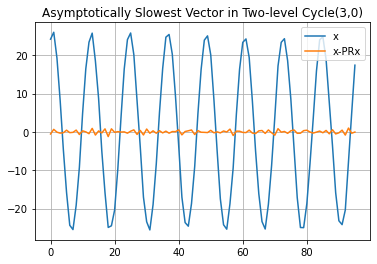

In [100]:
nu = 3
use_r_as_restriction = False

multilevel = hm.repetitive.locality.create_two_level_hierarchy(
    kh, discretization, n, R, p, aggregate_size, num_components, use_r_as_restriction=use_r_as_restriction)

y, _ = hm.repetitive.locality.two_level_conv_factor(multilevel, nu, print_frequency=1,
                                                    debug=False)

# Asymptotic vector.
plt.title("Asymptotically Slowest Vector in Two-level Cycle({},0)".format(nu))
y -= y.mean() # Remove zero component.
e = y - multilevel[1].p.dot(multilevel[1].r.dot(y))
plt.plot(y, label="x");
plt.plot(e, label="x-PRx");
plt.grid(True);
plt.legend();

In [101]:
# Calculate eigenpairs at all levels.
vl = []
laml = []
for l, level in enumerate(multilevel):
    a = level.a
    lam, v = eig(a.todense())
    lam = np.real(lam)
    ind = np.argsort(np.abs(lam))
    lam = lam[ind]
    v = v[:, ind]
    vl.append(v)
    laml.append(lam)
    print(l, "lam", lam[:12])
    
# Interpolate eigenvectors at all levels to the finest level.
num_levels = len(multilevel)
vl_finest = []
for l in range(num_levels):
    v = vl[l]
    for k in range(l, 0, -1):
        v = multilevel[k].p.dot(v)
    vl_finest.append(v)

0 lam [-0.     0.     0.064  0.064 -0.073 -0.073  0.12   0.12  -0.154 -0.154  0.167  0.167]
1 lam [-0.    -0.     0.064  0.064 -0.073 -0.073  0.12   0.12  -0.154 -0.154  0.166  0.166]


<!-- #### $P^T A Q$ Coarsening
This is not exactly a matrix multiplication $P^T A Q$, since $Q$ is not a uni-valued operator. It maps a point at the edge of the stencil of $P^T A$ to two values, one when it's at the edge and one when it's in the middle of the stencil. -->

In [102]:
# nu = 3
# p = p_experiment[False][-1]
# multilevel = hm.repetitive.locality.create_two_level_hierarchy(
#     kh, discretization, n, R, p, aggregate_size, num_components use_r_as_restriction=False)
# y, _ = hm.repetitive.locality.two_level_conv_factor(multilevel, nu, print_frequency=1,
#                                                    debug=False)


## Level 1->2 Coarsening
Are the equations at level 1 harder to solve than level 0 because of worse smoothing rates? Do we see a good coarsening ratio for an aggregate of size $4$ here too?

In [103]:
# Coarsening. Force 2 coarse vars per aggregate so we can test alignment.
aggregate_size = 4
num_components = 2

## Level 1 Relaxation

We run relaxation on $A x = 0$. $A$ has two null vectors; call $Y$ the $n \times 2$ matrix whose columns are these vectors. Let $x_0$ be a random[-1, 1] initial guess for $x$. We first project $x_0$ onto the range of $A$, that is,

$x_0 \longleftarrow x_0 - Y Y^T x_0^T\,,$

and use this as the initial guess for the run. Since the magnitude of $Y$ the exact solution is $0$, and relaxation doesn't change this magnitude, $e = x - x_0$ is a meaningful definition, which can also be used to calculate a meaningful RER.

A symmetry deviation 1.3877787807814457e-16
lam [-0.    -0.     0.064  0.064 -0.073 -0.073  0.12   0.12  -0.154 -0.154]
Y^T Y coming out of eig() [[ 1.    -0.264]
 [-0.264  1.   ]]
Y^T Y after Grahm-Schmidt [[1. 0.]
 [0. 1.]]
|imag(y)| 0.0
A*y [0. 0.]


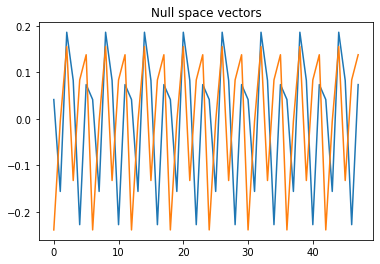

In [104]:
m1 = multilevel.sub_hierarchy(1)
level = m1.finest_level
a = level.a
lam, v = eig(a.todense())
# If A is real, it has an orthogonal set of eigenvectors.
print("A symmetry deviation", np.max(a - a.T))

lam = np.real(lam)
ind = np.argsort(np.abs(lam))
lam = lam[ind]
v = v[:, ind]
y = v[:, :2]  # normalized, but may not be orthogonal.
print("lam", lam[:10])
print("Y^T Y coming out of eig()", np.real(y.T.dot(y)))

# After Grahm-Schmidt, y is also real.
y[:, 1] -= (y[:, 0].dot(y[:, 1])) * y[:, 0]
y[:, 1] /= norm(y[:, 1])
print("Y^T Y after Grahm-Schmidt", np.real(y.T.dot(y)))
print("|imag(y)|", norm(np.imag(y)))
y = np.real(y)
print("A*y", norm(a.dot(y), axis=0))
plt.plot(y[:, 0])
plt.plot(y[:, 1])
plt.title("Null space vectors");

In [105]:
# Prepare initial guess that's orthogonal to the null space of A1.
x0 = hm.solve.run.random_test_matrix((a.shape[0], ), num_examples=5)
print(y.T.dot(x0))
x = x0 - y.dot(y.T.dot(x0))
print("y.dot(x)", y.T.dot(x))

[[-0.029 -0.015  0.095 -0.075 -0.076]
 [ 0.019 -0.035 -0.046  0.002 -0.059]]
y.dot(x) [[ 0.  0. -0. -0.  0.]
 [-0.  0.  0.  0. -0.]]


INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     4.025e-01                    4.458e-01    0.899
INFO     1     1.922e-01 (0.481) [0.481]    3.028e-01    0.635 (0.709)
INFO     2     7.519e-02 (0.396) [0.436]    2.267e-01    0.337 (0.530)
INFO     3     5.663e-02 (0.754) [0.522]    2.010e-01    0.286 (0.852)
INFO     4     4.225e-02 (0.749) [0.572]    1.855e-01    0.231 (0.812)
INFO     5     3.434e-02 (0.811) [0.614]    1.748e-01    0.198 (0.862)
INFO     6     2.937e-02 (0.853) [0.649]    1.666e-01    0.178 (0.895)
INFO     7     2.580e-02 (0.876) [0.677]    1.599e-01    0.162 (0.912)
INFO     8     2.312e-02 (0.893) [0.702]    1.544e-01    0.150 (0.925)
INFO     9     2.103e-02 (0.907) [0.722]    1.496e-01    0.141 (0.936)
INFO     10    1.935e-02 (0.918) [0.740]    1.455e-01    0.133 (0.943)
INFO     11    1.796e-02 (0.926) [0.755]    1.419e-01    0.126 (0.949)
INFO     12    1.679e-02 (0.933) [0.769]    1.386e-01    0.121 (0.955)
INFO 

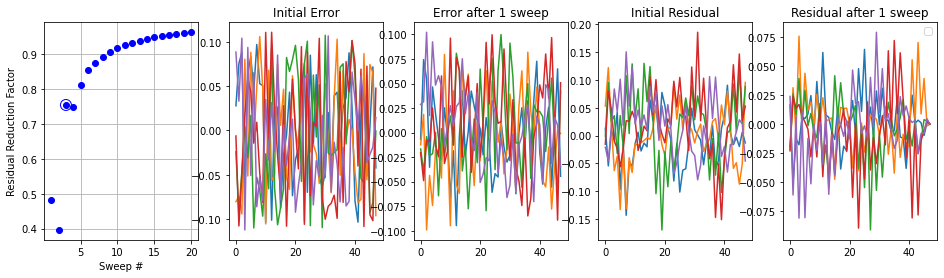

In [106]:
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    m1, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.98, max_sweeps=20, x0=x0)
num_sweeps = method_info["Kaczmarz"][1]

In [107]:
def plot_svd_coarsening_accuracy(level, num_sweeps: int, aggregate_size: int = 4):
    """Checks coarsening based on relaxed TVs, for different number of relaxation sweeps.
    If aggregate_size is not None, forces that aggregate size for the entire domain."""
    num_sweeps_values = 5 * 2 ** np.arange(8)

    fig, axs = plt.subplots(1, 3, figsize=(16, 4))
     
    # Create relaxed TVs.
    x_random = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=4 * aggregate_size)
    b = np.zeros_like(x_random)
    x = hm.solve.run.run_iterative_method(
        level.operator, lambda x: level.relax(x, b), x_random, num_sweeps=num_sweeps)[0]

    start, end = 0, aggregate_size
    x_aggregate_t = x[start:end].transpose()
    r, s = hm.repetitive.coarsening_repetitive.create_coarsening(x_aggregate_t, threshold)
    r = r.asarray()
    display(pd.DataFrame(r))

    # Relaxed vectors.
    ax = axs[0]
    for i in range(min(3, x.shape[1])):
        ax.plot(x[:, i]);
    ax.grid(True)
    ax.set_title(r"Test Vectors, $\nu={}$ sweeps".format(num_sweeps))

    ax = axs[1]
    # R should be real-valued, but cast just in case.
    for i, ri in enumerate(np.real(r)):
        ax.plot(ri)
    ax.set_title(r"Agg Size {} $n_c$ {}".format(r.shape[1], r.shape[0]))
    ax.set_ylabel(r"$R$ rows")
    ax.grid(True);

    # Singular values, normalized to sigma_max = 1.
    ax = axs[2]
    ax.plot(s / s[0], "rx")
    ax.set_title("Singular Values")
    ax.set_xlabel(r"$k$")
    ax.set_ylabel(r"$\sigma_k$")
    ax.grid(True);

    # TODO: replace by local mock cycle rate.
    nu_values = np.arange(1, 12)
    R = hrc.Coarsener(r).tile(level.a.shape[0] // aggregate_size)
    print("nu", "{:3d}".format(num_sweeps), "s", s / s[0], "Energy error", (1 - np.cumsum(s ** 2) / sum(s ** 2)) ** 0.5)
    mock_conv = np.array([hm.setup.auto_setup.mock_cycle_conv_factor(level, R, nu) for nu in nu_values])
    #hm.repetitive.locality.mock_conv_factor_for_domain_size(kh, discretization, r, aggregate_size, m * aggregate_size, nu_values)
    _LOGGER.info("Mock cycle conv {}".format(np.array2string(mock_conv, precision=3)))

#         # Generate coarse variables (R) on the non-repetitive domain.
#         r, aggregates, nc, energy_error = hm.repetitive.coarsening_repetitive.create_coarsening_domain(
#             x, threshold=threshold, fixed_aggregate_size=aggregate_size)
#         _LOGGER.info("Agg {}".format(np.array([len(aggregate) for aggregate in aggregates])))
#         _LOGGER.info("nc  {}".format(nc))
#         _LOGGER.info("Energy error mean {:.4f} max {:.4f}".format(np.mean(energy_error), np.max(energy_error)))
#         mock_conv_factor = np.array(
#             [hm.setup.auto_setup.mock_cycle_conv_factor(level, r, nu) for nu in np.arange(1, 16, dtype=int)])
#         _LOGGER.info("Mock cycle conv factor {}".format(np.array2string(mock_conv_factor, precision=3)))

,0,1,2,3
0,-0.46,-0.38,0.80,-0.12
1,-0.65,0.47,-0.23,-0.55


nu 300 s [1.    0.741 0.002 0.   ] Energy error [0.595 0.002 0.    0.   ]
INFO     Mock cycle conv [0.596 0.421 0.325 0.219 0.199 0.148 0.128 0.125 0.108 0.106 0.1  ]


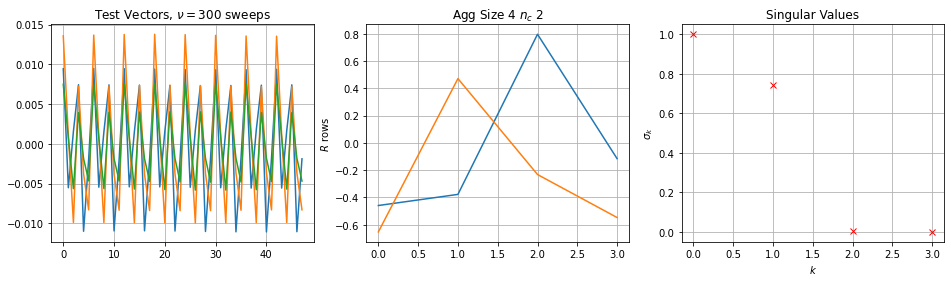

In [108]:
# #PCs revealed by relaxed vectors of increasing smoothness.
plot_svd_coarsening_accuracy(level, 300, 4)

In [109]:
nu = num_sweeps_on_vectors if num_sweeps_on_vectors is not None else num_sweeps
# Generate initial test vectors.
level = m1[0]
if ideal_tv:
    _LOGGER.info("Generating {} ideal TVs".format(num_examples))
    x, lam = hm.analysis.ideal.ideal_tv(level.a, num_examples)
else:
    _LOGGER.info("Generating {} TVs with {} sweeps".format(num_examples, nu))
    x = hm.setup.auto_setup.get_test_matrix(a, nu, num_examples=num_examples)
    _LOGGER.info("RER {:.3f}".format(norm(level.a.dot(x)) / norm(x)))
x_log.append(x)

INFO     Generating 4 TVs with 300 sweeps
INFO     RER 0.001


[1.    0.771 0.269 0.189]


,0,1,2,3,4,5,6,7,8,9
0,-0.65,0.14,0.47,-0.58,0.00,0.00,0.00,0.00,0.00,0.00
1,0.12,-0.79,0.59,0.14,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,-0.65,0.14,0.47,-0.58,0.00,0.00
3,0.00,0.00,0.00,0.00,0.12,-0.79,0.59,0.14,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.65,0.14


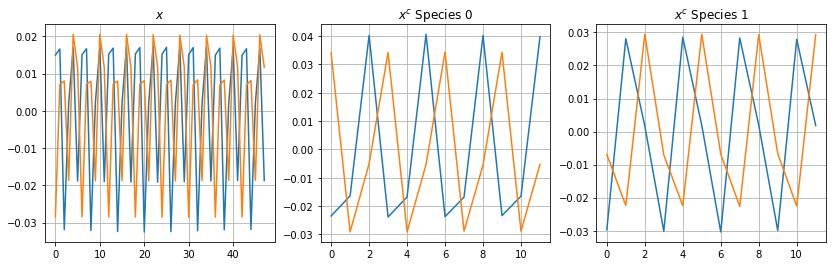

In [110]:
r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False)
print(s/s[0])
R = r.tile(level.size // aggregate_size)
xc = R.dot(x)
display(pd.DataFrame(R[:5,:10].todense()))
hm.repetitive.locality.plot_coarsening(R, x)

In [111]:
# Calculate local mock cycle convergence rate on a domain of size 4 * aggregate_size.
m = 4
nu_values = np.arange(1, 12)
mock_conv = np.array([hm.setup.auto_setup.mock_cycle_conv_factor(level, R, nu) for nu in nu_values])
#hm.repetitive.locality.mock_conv_factor_for_domain_size(kh, discretization, r, aggregate_size, m * aggregate_size, nu_values)
_LOGGER.info("Mock cycle conv |domain|={} {}".format(
    m * aggregate_size, np.array2string(mock_conv, precision=3)))

INFO     Mock cycle conv |domain|=16 [0.54  0.34  0.341 0.303 0.286 0.266 0.247 0.229 0.213 0.195 0.183]


In [112]:
# Mock cycle rates
# Relaxed vectors: [0.52  0.435 0.425 0.341 0.355 0.327 0.295 0.272 0.248 0.225 0.204]
# Ideal vectors: [0.525 0.468 0.378 0.382 0.356 0.268 0.298 0.271 0.247 0.225 0.204]

In [117]:
fine_location, coarse_location = location[:2]
xf = hm.setup.sampling.wrap_index_to_low_value(fine_location, multilevel.finest_level.size)
xc = hm.setup.sampling.wrap_index_to_low_value(coarse_location, multilevel.finest_level.size)

# Find nearest neighbors of each fine P^T*A point (pta_vars).
# These are INDICES into the rap_vars array.
nbhr = np.argsort(np.abs(xf[:, None] - xc), axis=1)


In [128]:
hm.setup.geometry.geometric_neighbors_from_locations(location[0], location[1], n, aggregate_size)[:, :4]

array([[ 0,  1, 46, 47],
       [ 0,  1, 46, 47],
       [ 0,  1,  2,  3],
       [ 0,  1,  2,  3]])

In [127]:
num_aggregates = int(np.ceil(multilevel[0].a.shape[0] / aggregate_size))
num_coarse_vars = nc * num_aggregates
np.mod(hm.setup.geometry.geometric_neighbors(aggregate_size, num_components), num_coarse_vars)

array([[ 0,  1, 46, 47],
       [ 0,  1, 46, 47],
       [ 0,  1,  2,  3],
       [ 0,  1,  2,  3]])